<a href="https://colab.research.google.com/github/shree180103/dcgan_mnist/blob/main/dcgan_with_fid_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
import torchvision
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets

In [2]:
torch.cuda.is_available()

True

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
# x and y are concatenated and send as one img in the in the disc. thus input channels of disc are 3*2=6

In [5]:
class Discriminator_y(nn.Module):
  def __init__(self,input_shape:int):
    super().__init__()
    self.patch_gan=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=1,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=1,padding=1,bias=False,padding_mode="reflect"),

    )

  def forward(self,y):
      return self.patch_gan(y)


In [6]:
class Discriminator_x(nn.Module):
  def __init__(self,input_shape:int):
    super().__init__()
    self.patch_gan=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=1,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=1,padding=1,bias=False,padding_mode="reflect"),

    )

  def forward(self,x):
      return self.patch_gan(x)


In [7]:
def test():
    x=torch.rand(size=(1,3,256,256)).to('cuda')
    y=torch.rand(size=(1,3,256,256)).to('cuda')
    model1=Discriminator_y(input_shape=3).to('cuda')
    model2=Discriminator_x(input_shape=3).to('cuda')
    
    preds=model1(x)
    print(preds.shape)
    preds=model2(y)
    print(preds.shape)

test()

torch.Size([1, 1, 30, 30])
torch.Size([1, 1, 30, 30])


In [8]:
class Generator_G(nn.Module):
  def __init__(self,img_channels:int):
    super().__init__()
    self.conv_block_down=nn.Sequential(
        nn.Conv2d(in_channels=img_channels,out_channels=64,kernel_size=7,stride=1,padding=3,bias=False,padding_mode="reflect"),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True)
    )
    self.conv_block_up=nn.Sequential(
        nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=3,stride=2,padding=1,output_padding=1,bias=False),
        nn.InstanceNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=3,stride=2,padding=1,output_padding=1,bias=False),
        nn.InstanceNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(in_channels=64,out_channels=3,kernel_size=7,stride=1,padding=3,bias=False,padding_mode="reflect")
        
    )

    self.conv_res_block=nn.Sequential(
        nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(256),
    )
    self.relu=nn.ReLU()

  def forward(self,x):
      x=self.conv_block_down(x)
      for i in range(9):
          res=x
          output=self.conv_res_block(x)
          x=self.relu(output+res)

      return torch.tanh(self.conv_block_up(x))
      
      
    
          


In [9]:
class Generator_F(nn.Module):
  def __init__(self,img_channels:int):
    super().__init__()
    self.conv_block_down=nn.Sequential(
        nn.Conv2d(in_channels=img_channels,out_channels=64,kernel_size=7,stride=1,padding=3,bias=False,padding_mode="reflect"),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True)
    )
    self.conv_block_up=nn.Sequential(
        nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=3,stride=2,padding=1,output_padding=1,bias=False),
        nn.InstanceNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=3,stride=2,padding=1,output_padding=1,bias=False),
        nn.InstanceNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(in_channels=64,out_channels=3,kernel_size=7,stride=1,padding=3,bias=False,padding_mode="reflect")
        
    )

    self.conv_res_block=nn.Sequential(
        nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(256),
    )
    self.relu=nn.ReLU()

  def forward(self,x):
      x=self.conv_block_down(x)
      for i in range(9):
          res=x
          output=self.conv_res_block(x)
          x=self.relu(output+res)

      return torch.tanh(self.conv_block_up(x))
      
      
    

In [10]:
def test():
    x=torch.rand(size=(1,3,256,256)).to('cuda')
    y=torch.rand(size=(1,3,256,256)).to('cuda')
    model1=Generator_G(img_channels=3).to('cuda')
    model2=Generator_F(img_channels=3).to('cuda')
    preds=model1(x)
    print(preds.shape)
    preds=model2(x)
    print(preds.shape)

test()

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [11]:
device="cuda" if torch.cuda.is_available() else "cpu"
# device="cpu"
n_c=3

gen_G=Generator_G(img_channels=n_c).to(device)
gen_G.apply(weights_init)

gen_F=Generator_F(img_channels=n_c).to(device)
gen_F.apply(weights_init)

disc_x=Discriminator_x(input_shape=n_c).to(device)
disc_x.apply(weights_init)

disc_y=Discriminator_y(input_shape=n_c).to(device)
disc_y.apply(weights_init)


Discriminator_y(
  (patch_gan): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(5

In [12]:
device

'cuda'

In [13]:
from PIL import Image
import numpy as np
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
# training params
batch_size=1
lr=0.0002
img_size=256
n_c=3
lambda_cyc=10
lambda_id=0



In [14]:
both_x_and_y_transform=A.Compose([A.Resize(width=256,height=256),A.HorizontalFlip(0.5)],additional_targets={"image0":"image"})#seperating x and y

transform_X=A.Compose([A.Normalize([0.5 for _ in range(n_c)],[0.5 for _ in range(n_c)]),ToTensorV2()])
transform_Y=A.Compose([A.Normalize([0.5 for _ in range(n_c)],[0.5 for _ in range(n_c)]),ToTensorV2()])

In [15]:
from torchvision.utils import save_image
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class MapDataset(Dataset):
    def __init__(self, input_dir, target_dir):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.input_files = os.listdir(self.input_dir)
        self.target_files = os.listdir(self.target_dir)

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, index):
        input_img_file = self.input_files[index]
        target_img_file = self.target_files[index]

        input_img_path = os.path.join(self.input_dir, input_img_file)
        target_img_path = os.path.join(self.target_dir, target_img_file)

        input_image = np.array(Image.open(input_img_path))
        target_image = np.array(Image.open(target_img_path))

        # Apply augmentations if necessary
        augmentations = both_x_and_y_transform(image=input_image, image0=target_image)
        input_image = augmentations["image"]
        target_image = augmentations["image0"]

        if input_image.ndim == 2:  # Grayscale
            input_image = np.stack((input_image,) * 3, axis=-1)  # Convert to 3 channels

        if target_image.ndim == 2:  # Grayscale
            target_image = np.stack((target_image,) * 3, axis=-1)  # Convert to 3 channels

        # Apply specific transforms if needed
        input_image = transform_X(image=input_image)["image"]
        target_image = transform_Y(image=target_image)["image"]

        return input_image, target_image


# class MapDataset(Dataset):
#     def __init__(self, root_dir):
#         self.root_dir = root_dir
#         self.list_files = os.listdir(self.root_dir)

#     def __len__(self):
#         return len(self.list_files)

#     def __getitem__(self, index):
#         img_file = self.list_files[index]
#         img_path = os.path.join(self.root_dir, img_file)
#         image = np.array(Image.open(img_path))
#         input_image = image[:,:256,:]
#         target_image = image[:,256:, :]

#         augmentations = both_x_and_y_transform(image=input_image, image0=target_image)
#         input_image = augmentations["image"]
#         target_image = augmentations["image0"]

#         input_image = transform_X(image=input_image)["image"]
#         target_image = transform_Y(image=target_image)["image"]

#         return input_image, target_image


# if __name__ == "__main__":
#     dataset = MapDataset("data_maps/maps/maps/train/")
#     loader = DataLoader(dataset, batch_size=5)
#     for x, y in loader:
#         save_image(x, "x.png")
#         save_image(y, "y.png")
#         import sys

#         exit()

In [16]:
train_dataset=MapDataset(input_dir="data_horese2zebra/horse2zebra/trainA/",target_dir="data_horese2zebra/horse2zebra/trainB/")
train_data_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

val_dataset=MapDataset(input_dir="data_horese2zebra/horse2zebra/testA",target_dir="data_horese2zebra/horse2zebra/testB")
val_data_loader=DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=True)

# test_dataset=MapDataset(input_dir="data_sketch_to_face/train/sketches",target_dir="data_sketch_to_face/train/photos")
# test_data_loader=DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

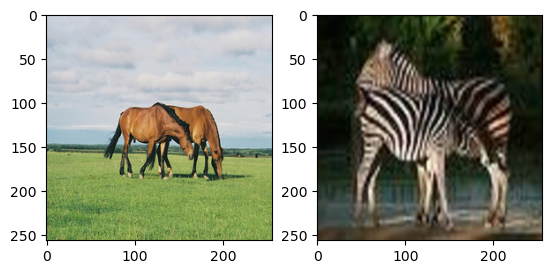

In [17]:
image,label=next(iter(train_data_loader))
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow((image[0]*0.5+0.5).permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow((label[0]*0.5+0.5).permute(1,2,0))

plt.show()

In [18]:
# writer_fake=SummaryWriter("logs/GAN_MNIST/fake")

# writer_real=SummaryWriter("logs/GAN_MNIST/real")

# step = 0

# fixed_noise = torch.randn(size=(64,z_dim,1,1))

In [19]:
# z=torch.rand(size=(1,100,1,1))
# z.shape

In [20]:
# img,label=next(iter(data_loader))
# img.shape

In [21]:
# !pip install torchinfo

In [22]:
# from torchinfo import summary

# summary(disc,input_size=[1,3,64,64])

In [23]:
# disc.eval()
# with torch.inference_mode():
#   print(disc(torch.rand(size=(1,1,64,64)).to('cuda')).shape)


In [24]:
# disc.eval()
# with torch.inference_mode():
#   print(disc(torch.rand(size=(1,1,64,64)).to('cuda')).shape)

In [25]:
# summary(gen,input_size=[1,3,265,256])

In [26]:
# gen.eval()
# with torch.inference_mode():
#   print(gen(z.to('cuda')).shape)

In [27]:
import math
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import inception_v3
from torchvision.models import Inception_V3_Weights
import scipy
import numpy as np

In [28]:
loss_fn=nn.MSELoss()
loss_l1=nn.L1Loss()

optimizer_disc_y=torch.optim.Adam(params=disc_y.parameters(),lr=lr,betas=(0.5,0.999))
optimizer_disc_x=torch.optim.Adam(params=disc_x.parameters(),lr=lr,betas=(0.5,0.999))

optimizer_gen_G=torch.optim.Adam(params=gen_G.parameters(),lr=lr,betas=(0.5,0.999))
optimizer_gen_F=torch.optim.Adam(params=gen_F.parameters(),lr=lr,betas=(0.5,0.999))

In [29]:
from tqdm.auto import tqdm

epochs=150
LOSS_Dx=[]
LOSS_G=[]
LOSS_Dy=[]
LOSS_F=[]
fid_scores=[]

for epoch in tqdm(range(epochs)):
  for batch_idx,(x,y) in enumerate(train_data_loader):
      

    ## traing the discriminators Dx and Dy

    disc_y.zero_grad()
    disc_y_real=disc_y(y.to(device))
      
    y_fake=gen_G(x.to(device))
    
    disc_y_fake=disc_y(y_fake.detach().to(device))

    loss_disc_y=(loss_fn(disc_y_real,torch.ones_like(disc_y_real))+loss_fn(disc_y_fake,torch.zeros_like(disc_y_fake)))/2
      
    LOSS_Dy.append(loss_disc_y.item())

    loss_disc_y.backward()

    optimizer_disc_y.step()

    disc_x.zero_grad()
    disc_x_real=disc_x(x.to(device))
      
    x_fake=gen_F(y.to(device))
    
    disc_x_fake=disc_x(x_fake.detach().to(device))

    loss_disc_x=(loss_fn(disc_x_real,torch.ones_like(disc_x_real))+loss_fn(disc_x_fake,torch.zeros_like(disc_x_fake)))/2
    LOSS_Dx.append(loss_disc_x.item())

    loss_disc_x.backward()

    optimizer_disc_x.step()

    #training generators G  and F 
    gen_G.zero_grad()
    gen_F.zero_grad()

    fool_logits_y=disc_y(y_fake.to(device))
    fool_logits_x=disc_x(x_fake.to(device))

    f_g_x=gen_G(y_fake.to(device))
    g_f_y=gen_F(x_fake.to(device))

    cyc_loss_g=lambda_cyc*(loss_l1(f_g_x,x.to(device)))
    cyc_loss_f=lambda_cyc*(loss_l1(g_f_y,y.to(device)))

    # id_y=gen_G(y.to(device))
    # id_x=gen_F(x.to(device))

    # id_y_loss=lambda_id*loss_l1(id_y,y.to(device))
    # id_x_loss=lambda_id*loss_l1(id_x,x.to(device))

    # noot using id_loss for this dataset
    

    loss_gen_G=loss_fn(fool_logits_y,torch.ones_like(fool_logits_y))+cyc_loss_g
    loss_gen_F=loss_fn(fool_logits_x,torch.ones_like(fool_logits_x)) +cyc_loss_f
    
    LOSS_G.append(loss_gen_G.item())
    LOSS_G.append(loss_gen_F.item())

    loss_gen_G.backward()
    optimizer_gen_G.step()
      
    loss_gen_F.backward()
    optimizer_gen_F.step()

    if batch_idx== 0:
           
            print(
                f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_data_loader)} \
                  Loss Dx: {loss_disc_x:.4f}, loss G: {loss_gen_G:.4f},Loss Dy: {loss_disc_y:.4f}, loss F: {loss_gen_F:.4f}"
            )











  0%|          | 0/150 [00:00<?, ?it/s]

Epoch [0/150] Batch 0/1067                   Loss Dx: 1.9724, loss G: 22.5159,Loss Dy: 1.8927, loss F: 11.2684
Epoch [1/150] Batch 0/1067                   Loss Dx: 0.1849, loss G: 3.4219,Loss Dy: 0.3339, loss F: 2.7748
Epoch [2/150] Batch 0/1067                   Loss Dx: 0.3893, loss G: 3.1690,Loss Dy: 0.2105, loss F: 2.7250
Epoch [3/150] Batch 0/1067                   Loss Dx: 0.2315, loss G: 2.8903,Loss Dy: 0.2696, loss F: 2.3274
Epoch [4/150] Batch 0/1067                   Loss Dx: 0.2243, loss G: 2.4164,Loss Dy: 0.2667, loss F: 2.0351
Epoch [5/150] Batch 0/1067                   Loss Dx: 0.4408, loss G: 2.1500,Loss Dy: 0.1361, loss F: 1.9826
Epoch [6/150] Batch 0/1067                   Loss Dx: 0.3529, loss G: 1.8881,Loss Dy: 0.3116, loss F: 2.1054
Epoch [7/150] Batch 0/1067                   Loss Dx: 0.1778, loss G: 2.2953,Loss Dy: 0.3133, loss F: 2.3180
Epoch [8/150] Batch 0/1067                   Loss Dx: 0.0928, loss G: 2.3638,Loss Dy: 0.1290, loss F: 2.0852
Epoch [9/150] Bat

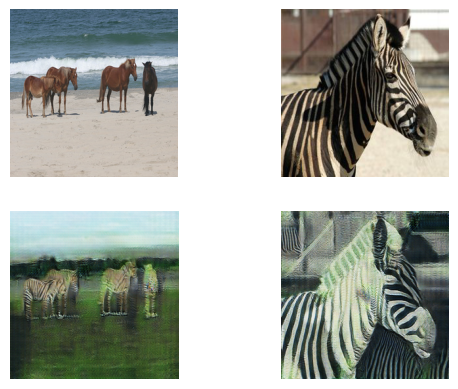

In [68]:
x,y=next(iter(train_data_loader))
import matplotlib.pyplot as plt
plt.subplot(2,2,1)
plt.imshow((x[0]*0.5+0.5).permute(1,2,0))
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow((y[0]*0.5+0.5).permute(1,2,0))
plt.axis('off')
y_fake=gen_G(x.to(device))
plt.subplot(2,2,3)
plt.imshow((y_fake[0]*0.5+0.5).permute(1,2,0).cpu().detach())
plt.axis('off')
x_fake=gen_G(y.to(device))
plt.subplot(2,2,4)
plt.imshow((x_fake[0]*0.5+0.5).permute(1,2,0).cpu().detach())
plt.axis('off')
plt.show()


In [31]:
# plt.plot(LOSS_D,label="Discriminator Loss")
# plt.plot(LOSS_G,label="Generator Loss")
# plt.legend()
# plt.show()

NameError: name 'LOSS_D' is not defined

In [52]:
class PartialInceptionNetwork(nn.Module):
  def __init__(self):
    super(PartialInceptionNetwork, self).__init__()
    self.inception_model = inception_v3(weights=Inception_V3_Weights.DEFAULT)  #initializing pretrsined model
    self.inception_model.Mixed_7c.register_forward_hook(self.output_hook)
    self.output = None

  def output_hook(self, module, input, output):
    self.mixed_7c_output = output

  def forward(self, x):
    assert x.shape[1:] == (3, 299, 299), "Input shape should be (batch_size, 3, 299, 299)"
    self.inception_model(x)
    activations = self.mixed_7c_output
    activations = F.adaptive_avg_pool2d(activations, (1, 1))
    activations = activations.view(x.shape[0],2048)
    return activations

net=PartialInceptionNetwork().to(device)

def fid_score(real_images, gen_images,batch_size):
  real_activations = []
  gen_activations = []
  num_steps=int(math.ceil(float(len(real_images))/float(batch_size)))
  for i in range(num_steps):
    s = i * batch_size
    e=(1+i) * batch_size

    mini_real_batch=real_images[s:e]
    mini_gen_batch=gen_images[s:e]

    batch_real=Variable(mini_real_batch).to(device)
    batch_gen=Variable(mini_gen_batch).to(device)

  features_real=net(batch_real)
  features_gen=net(batch_gen)

  real_activations.append(features_real)
  gen_activations.append(features_gen)

  features_real=torch.cat(real_activations,0)
  features_gen=torch.cat(gen_activations,0)

  xr=features_real.cpu().detach().numpy()
  xg=features_gen.cpu().detach().numpy()

  u1=np.mean(xr,axis=0)
  u2=np.mean(xg,axis=0)
  s1=np.cov(xr,rowvar=False)
  s2=np.cov(xg,rowvar=False)
  print(s1.shape)
  print(s2.shape)

  diff=u1-u2
  diff_squared=diff.dot(diff)

  prod=np.dot(s1,s2)

  sqrt_prod,_=scipy.linalg.sqrtm(prod,disp=False)

  if np.iscomplexobj(sqrt_prod):
      sqrt_prod=sqrt_prod.real

  prod_tr=np.trace(sqrt_prod)

  fid_score=diff_squared+np.trace(s1)+np.trace(s2)-2*prod_tr

  return fid_score

In [69]:
gen_images=y_fake.view(-1,1,256,256)
gen_images=gen_images.repeat(1,3,1,1)
gen_res_images=F.interpolate(gen_images,size=(299,299))
real_images = x.view(-1, 1, 256, 256) # Reshape real_images similar to gen_images
real_images = real_images.repeat(1, 3, 1, 1) # Repeat channels for real_images
real_images = F.interpolate(real_images, size=(299, 299)) # Resize 
net.eval()  # Set the model to evaluation mode
fid = fid_score(real_images, gen_res_images,1)
print(fid)

452.76867242607295


In [53]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import math
import scipy

# Assuming y_fake is your generated images (batch_size, 3, 256, 256)
# and x is your real images (batch_size, 3, 256, 256)

# Resize generated images to (299, 299)
gen_res_images = F.interpolate(y_fake, size=(299, 299)) 

# Resize real images to (299, 299)
real_res_images = F.interpolate(y, size=(299, 299))

# Your PartialInceptionNetwork class definition here (as given above)
# net = PartialInceptionNetwork().to(device)

# FID score calculation function
def fid_score(real_images, gen_images, batch_size):
    real_activations = []
    gen_activations = []
    num_steps = int(math.ceil(float(len(real_images)) / float(batch_size)))
    
    for i in range(num_steps):
        s = i * batch_size
        e = (i + 1) * batch_size

        mini_real_batch = real_images[s:e]
        mini_gen_batch = gen_images[s:e]

        batch_real = Variable(mini_real_batch).to(device)
        batch_gen = Variable(mini_gen_batch).to(device)

        # Get activations from Inception network
        features_real = net(batch_real)
        features_gen = net(batch_gen)

        real_activations.append(features_real)
        gen_activations.append(features_gen)

    # Concatenate all activations
    features_real = torch.cat(real_activations, 0)
    features_gen = torch.cat(gen_activations, 0)

    # Convert activations to numpy for FID computation
    xr = features_real.cpu().detach().numpy()
    xg = features_gen.cpu().detach().numpy()

    # Mean and covariance of activations
    u1 = np.mean(xr, axis=0)
    u2 = np.mean(xg, axis=0)
    s1 = np.cov(xr, rowvar=False)
    s2 = np.cov(xg, rowvar=False)

    # Calculate FID
    diff = u1 - u2
    diff_squared = diff.dot(diff)

    prod = np.dot(s1, s2)
    sqrt_prod, _ = scipy.linalg.sqrtm(prod, disp=False)

    if np.iscomplexobj(sqrt_prod):
        sqrt_prod = sqrt_prod.real

    prod_tr = np.trace(sqrt_prod)

    fid_score = diff_squared + np.trace(s1) + np.trace(s2) - 2 * prod_tr

    return fid_score

# Example usage:
net.eval()  # Set the model to evaluation mode

# Calculate FID score between real and generated images
fid = fid_score(real_res_images, gen_res_images, batch_size=4)  # Adjust batch_size as needed
print(fid)


ValueError: Non-matrix input to matrix function.

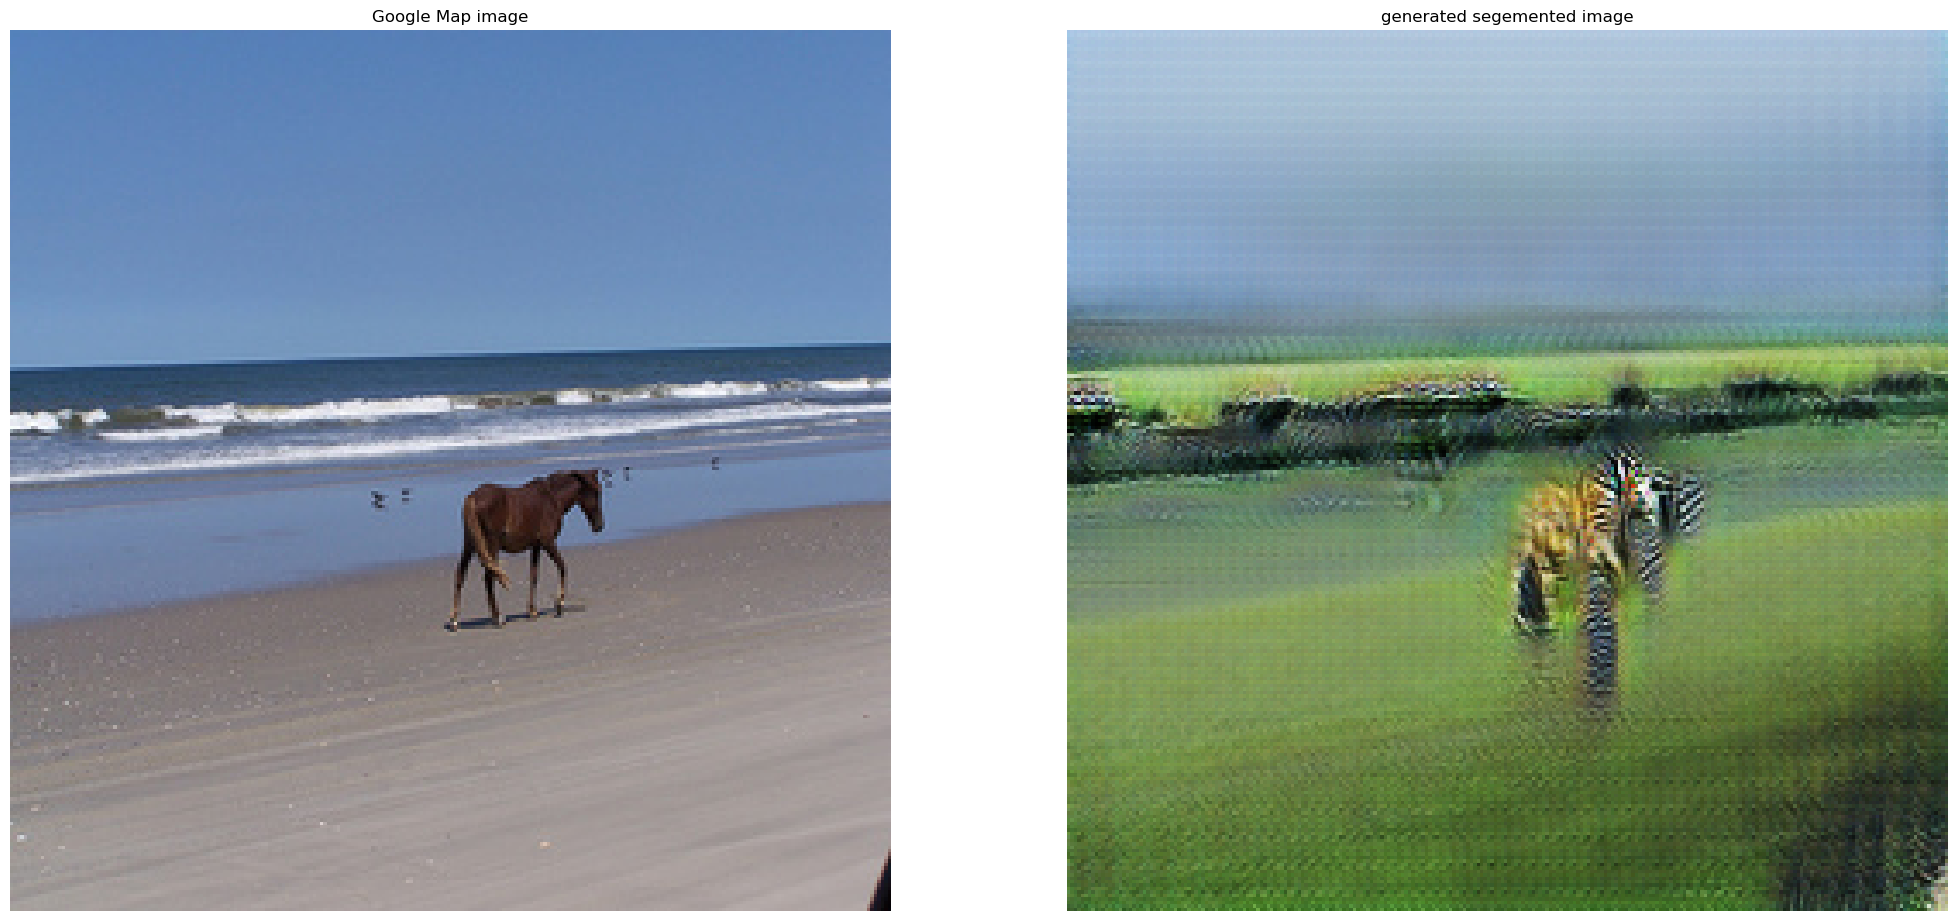

In [56]:
from torchvision.utils import make_grid

# Display images
def show_images(real_images, fake_images):


    

    # Create a grid of images
    real_grid = make_grid(real_images, nrow=8)
    fake_grid = make_grid(fake_images, nrow=8)

    plt.figure(figsize=(25,25))

    # Plot real images
    plt.subplot(1, 2, 1)
    plt.title("Google Map image")
    plt.imshow((real_grid*0.5+0.5).permute(1, 2, 0).detach())
    plt.axis('off')

    # Plot fake images
    plt.subplot(1, 2, 2)
    plt.title("generated segemented image")
    plt.imshow((fake_grid*0.5+0.5).cpu().permute(1, 2, 0).detach())
    plt.axis('off')

    plt.show()

# Hyperparameters
batch_size = 32
noise_dim = 100

show_images(x,y_fake)

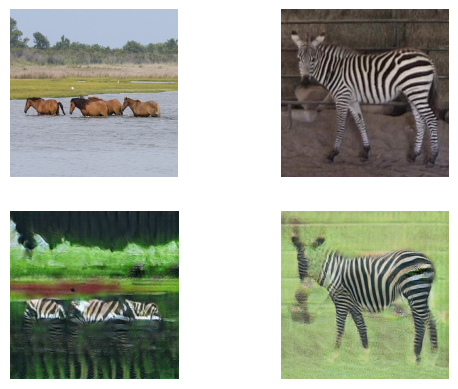

In [75]:
x,y=next(iter(val_data_loader))
import matplotlib.pyplot as plt
plt.subplot(2,2,1)
plt.imshow((x[0]*0.5+0.5).permute(1,2,0))
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow((y[0]*0.5+0.5).permute(1,2,0))
plt.axis('off')
y_fake=gen_G(x.to(device))
plt.subplot(2,2,3)
plt.imshow((y_fake[0]*0.5+0.5).permute(1,2,0).cpu().detach())
plt.axis('off')
x_fake=gen_G(y.to(device))
plt.subplot(2,2,4)
plt.imshow((x_fake[0]*0.5+0.5).permute(1,2,0).cpu().detach())
plt.axis('off')
plt.show()

In [ ]:
# class process(Dataset):
#     def __init__(self, input_dir):
#         self.input_dir = input_dir
#         self.input_files = os.listdir(self.input_dir)

#     def __len__(self):
#         return len(self.input_files)

#     def __getitem__(self, index):
#         input_img_file = self.input_files[index]


#         input_img_path = os.path.join(self.input_dir, input_img_file)

#         input_image = np.array(Image.open(input_img_path))

#         # Apply augmentations if necessary
#         augmentations = both_x_and_y_transform(image=input_image)
#         input_image = augmentations["image"]
#         if input_image.shape[-1] == 4:
#             input_image = input_image[..., :3]
#         # target_image = augmentations["image0"]

#         # Apply specific transforms if needed
#         input_image = transform_X(image=input_image)["image"]
#         # target_image = transform_Y(image=target_image)["image"]

#         return input_image


In [ ]:
# test_dataset=process(input_dir="data_comics/test_faces")
# # test_data_loader=DataLoader(dataset=test_dataset,batch_size=2,shuffle=True)

In [ ]:
# x,y=next(iter(test_data_loader))
# import matplotlib.pyplot as plt
# plt.subplot(1,3,1)
# plt.imshow((x[0]*0.5+0.5).permute(1,2,0))
# plt.axis('off')
# plt.subplot(1,3,2)
# plt.imshow((y[0]*0.5+0.5).permute(1,2,0))
# plt.axis('off')
# y_fake=gen(x.to(device))
# plt.subplot(1,3,3)
# plt.imshow((y_fake[0]*0.5+0.5).permute(1,2,0).cpu().detach())
# plt.axis('off')
# plt.show()